In [1]:
!pip install pycaret

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Explore Ai/insurance_claims_raw.xlsx'
df = pd.read_excel(path)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48.0,521585,2014-10-17,OH,250/500,1000.0,1406.91,0,466132,...,YES,71610.0,6510.0,13020.0,52080,Saab,92x,2004,Y,NaN
1,228,42.0,342868,2006-06-27,IN,250/500,2000.0,1197.22,5000000,468176,...,?,5070.0,780.0,780.0,3510,Mercedes,E400,2007,Y,NaN
2,134,29.0,687698,2000-09-06,OH,100/300,2000.0,1413.14,5000000,430632,...,NO,34650.0,7700.0,3850.0,23100,Dodge,RAM,2007,N,NaN
3,256,41.0,227811,1990-05-25,IL,250/500,2000.0,1415.74,6000000,608117,...,NO,63400.0,6340.0,6340.0,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44.0,367455,2014-06-06,IL,500/1000,1000.0,1583.91,6000000,610706,...,NO,6500.0,1300.0,650.0,4550,Accura,RSX,2009,N,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          998 non-null    float64       
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            998 non-null    float64       
 7   policy_annual_premium        997 non-null    float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      999 non-null   

In [6]:
df_pro = df[df['insured_occupation']=='prof-specialty']
education_level_mode = df_pro['insured_education_level'].mode()[0]
df['insured_education_level'].fillna(education_level_mode, inplace=True)

In [7]:
df_pro = df[df['insured_occupation']=='prof-specialty']
education_level_mode = df_pro['insured_education_level'].mode()[0]
df['insured_education_level'].fillna(education_level_mode, inplace=True)

In [8]:
df.loc[11, 'incident_state']='Illinois'
df.loc[112, 'incident_state']='Ohio'

In [9]:
df_fem =df[(df['insured_sex']=='FEMALE') & (df['insured_education_level']=='PhD') & (df['insured_occupation'] == 'armed-forces')]
insured_hob_f = df_fem['insured_hobbies'].mode()[0]
df.loc[3, 'insured_hobbies'] = insured_hob_f

df_mal =df[(df['insured_sex']=='MALE') & (df['age']> 40) & (df['insured_education_level']=='Associate') ]
insured_hob_m = df_mal['insured_hobbies'].mode()[0]  # Get the first mode value
df.loc[4, 'insured_hobbies'] = insured_hob_m

In [10]:
df_age_F = df[(df['insured_sex']=='FEMALE') & (df['months_as_customer']> 200)]
age_F = df_age_F['age'].mode()[0]
df.loc[81, 'age'] = age_F

df_age_F_C = df[(df['insured_sex']=='FEMALE') & (df['months_as_customer']> 30)]
age_F_C = df_age_F_C['age'].mode()[0]
df.loc[42, 'age'] = age_F_C

In [11]:
cap_gain_mean = round(df['capital-gains'].mean(),2)

df['capital-gains'].fillna(cap_gain_mean, inplace=True)

In [12]:
df['policy_deductable'].fillna(df['policy_deductable'].mean(), inplace = True)
df['policy_annual_premium'].fillna(df['policy_annual_premium'].mean(), inplace = True)


In [13]:
df['property_claim'] = df['property_claim'].fillna(df['total_claim_amount'] - df['vehicle_claim'] - df['injury_claim'])
df['injury_claim'] = df['injury_claim'].fillna(df['total_claim_amount'] - df['vehicle_claim'] - df['property_claim'])
df['total_claim_amount'] = df['total_claim_amount'].fillna(df['injury_claim'] + df['vehicle_claim'] + df['property_claim'])


In [14]:
df_contacted = df[df['authorities_contacted'].isna()]

In [15]:
df_contacted['incident_severity'].value_counts()

incident_severity
Minor Damage      50
Trivial Damage    41
Major Damage       1
Total Loss         1
Name: count, dtype: int64

In [16]:
df['authorities_contacted'].fillna('unknown', inplace = True)


In [17]:
df = df.drop('_c39', axis=1)

In [18]:

def create_time_features(df, time_col_name='time'):
  """
  This function takes a DataFrame and a column name (default 'time') containing
  datetime objects and adds new features including year, month, day, day of week
  (string representation), and hour.

  Args:
      df (pandas.DataFrame): The DataFrame containing the 'time' column.
      time_col_name (str, optional): The name of the column containing datetime data.
          Defaults to 'time'.

  Returns:
      pandas.DataFrame: The modified DataFrame with new time-based features.
  """
  # Convert 'time' column to datetime format (assuming valid datetime strings)
  df[time_col_name] = pd.to_datetime(df[time_col_name])

  year = time_col_name +'_year'
  month = time_col_name +'_month'
  day = time_col_name +'_day'
  day_of_week = time_col_name +'_day_of_week'

  # Extract features from the datetime column
  df[year] = df[time_col_name].dt.year
  df[month] = df[time_col_name].dt.month
  df[day] = df[time_col_name].dt.day
  df[day_of_week] = df[time_col_name].dt.dayofweek

  # Mapping for day of week (Monday=0, Sunday=6)
  day_of_week_mapping = {
      0: 'Monday',
      1: 'Tuesday',
      2: 'Wednesday',
      3: 'Thursday',
      4: 'Friday',
      5: 'Saturday',
      6: 'Sunday'
  }
  df[day_of_week] = df[day_of_week].map(day_of_week_mapping)

  # Mapping for month
  month_mapping = {
      1: 'January',
      2: 'Febuary',
      3: 'March',
      4: 'April',
      5: 'May',
      6: 'June',
      7: 'July',
      8: 'August',
      9: 'September',
      10: 'October',
      11: 'November',
      12: 'December'
  }
  df[month] = df[month].map(month_mapping)

  return df.drop(time_col_name, axis=1)

In [19]:
df =create_time_features(df, time_col_name='policy_bind_date')
df =create_time_features(df, time_col_name='incident_date')


In [20]:
df.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,auto_year,fraud_reported,policy_bind_date_year,policy_bind_date_month,policy_bind_date_day,policy_bind_date_day_of_week,incident_date_year,incident_date_month,incident_date_day,incident_date_day_of_week
0,328,48.0,521585,OH,250/500,1000.0,1406.91,0,466132,MALE,...,2004,Y,2014,October,17,Friday,2015,January,25,Sunday
1,228,42.0,342868,IN,250/500,2000.0,1197.22,5000000,468176,MALE,...,2007,Y,2006,June,27,Tuesday,2015,January,21,Wednesday
2,134,29.0,687698,OH,100/300,2000.0,1413.14,5000000,430632,FEMALE,...,2007,N,2000,September,6,Wednesday,2015,Febuary,22,Sunday
3,256,41.0,227811,IL,250/500,2000.0,1415.74,6000000,608117,FEMALE,...,2014,Y,1990,May,25,Friday,2015,January,10,Saturday
4,228,44.0,367455,IL,500/1000,1000.0,1583.91,6000000,610706,MALE,...,2009,N,2014,June,6,Friday,2015,Febuary,17,Tuesday


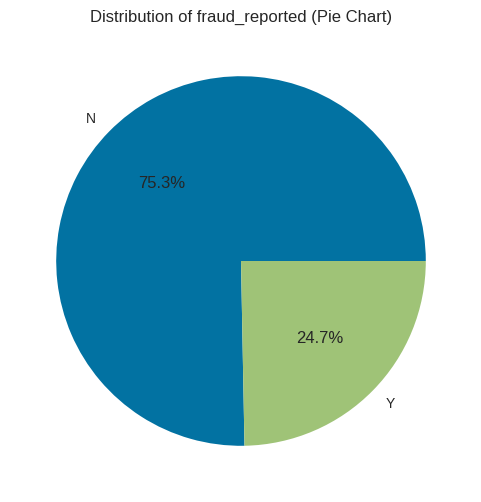

In [21]:
# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Count occurrences of each category
category_counts = df['fraud_reported'].value_counts()

# Create pie chart slices
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')  # Format percentage labels
plt.title('Distribution of fraud_reported (Pie Chart)')
plt.show()

In [22]:
fraud_binary = {
      'Y': 0, #fraud
      'N': 1  #no fraud
  }

Y= df['fraud_reported'].map(fraud_binary)
X= df.drop('fraud_reported', axis=1)

In [23]:
X = pd.get_dummies(df,dtype=int)
# Again we make sure that all the column names have underscores instead of whitespaces
X.columns = [col.replace(" ","_") for col in X.columns]
X.head()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,incident_date_month_Febuary,incident_date_month_January,incident_date_month_March,incident_date_day_of_week_Friday,incident_date_day_of_week_Monday,incident_date_day_of_week_Saturday,incident_date_day_of_week_Sunday,incident_date_day_of_week_Thursday,incident_date_day_of_week_Tuesday,incident_date_day_of_week_Wednesday
0,328,48.0,521585,1000.0,1406.91,0,466132,53300.0,0,5,...,0,1,0,0,0,0,1,0,0,0
1,228,42.0,342868,2000.0,1197.22,5000000,468176,0.0,0,8,...,0,1,0,0,0,0,0,0,0,1
2,134,29.0,687698,2000.0,1413.14,5000000,430632,35100.0,0,7,...,1,0,0,0,0,0,1,0,0,0
3,256,41.0,227811,2000.0,1415.74,6000000,608117,48900.0,-62400,5,...,0,1,0,0,0,1,0,0,0,0
4,228,44.0,367455,1000.0,1583.91,6000000,610706,66000.0,-46000,20,...,1,0,0,0,0,0,0,0,1,0


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [25]:
original_cols = X.columns

# Create a new DataFrame with original column names
#X_scaled_df = pd.DataFrame(columns=original_cols)

# Assign scaled values to DataFrame columns (assuming each column is scaled independently)
X_scaled_df = pd.DataFrame(X_scaled, columns=original_cols)


In [26]:
X_scaled_df.head()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,incident_date_month_Febuary,incident_date_month_January,incident_date_month_March,incident_date_day_of_week_Friday,incident_date_day_of_week_Monday,incident_date_day_of_week_Saturday,incident_date_day_of_week_Sunday,incident_date_day_of_week_Thursday,incident_date_day_of_week_Tuesday,incident_date_day_of_week_Wednesday
0,1.078140,0.989643,-0.095953,-0.219992,0.614945,-0.479476,-0.489529,1.010347,0.953851,-0.956261,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,-0.44614,2.564324,-0.410152,-0.395056,-0.411814
1,0.208995,0.332000,-0.791527,1.418454,-0.245230,1.697980,-0.461008,-0.904472,0.953851,-0.524475,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,-0.44614,-0.389966,-0.410152,-0.395056,2.428282
2,-0.608002,-1.092893,0.550566,1.418454,0.640501,1.697980,-0.984885,0.356506,0.953851,-0.668404,...,1.057660,-1.032529,-0.110208,-0.406818,-0.396746,-0.44614,2.564324,-0.410152,-0.395056,-0.411814
3,0.452355,0.222393,-1.239334,1.418454,0.651167,2.133471,1.491682,0.852276,-1.267577,-0.956261,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,2.24145,-0.389966,-0.410152,-0.395056,-0.411814
4,0.208995,0.551214,-0.695834,-0.219992,1.341021,2.133471,1.527808,1.466598,-0.683741,1.202666,...,1.057660,-1.032529,-0.110208,-0.406818,-0.396746,-0.44614,-0.389966,-0.410152,2.531286,-0.411814


In [27]:
X_scaled_df['fraud_reported']= Y


In [28]:
X_scaled_df['fraud_reported'].value_counts()

fraud_reported
1    753
0    247
Name: count, dtype: int64

In [29]:
s = ClassificationExperiment()
clf1 = setup(data = X_scaled_df, target = 'fraud_reported')


,Description,Value
0,Session id,316
1,Target,fraud_reported
2,Target type,Binary
3,Original data shape,"(1000, 1201)"
4,Transformed data shape,"(1000, 1201)"
5,Transformed train set shape,"(700, 1201)"
6,Transformed test set shape,"(300, 1201)"
7,Numeric features,1200
8,Preprocess,True
9,Imputation type,simple


In [30]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(X_scaled_df, target = 'fraud_reported', session_id = 123, train_size = 0.8)

,Description,Value
0,Session id,123
1,Target,fraud_reported
2,Target type,Binary
3,Original data shape,"(1000, 1201)"
4,Transformed data shape,"(1000, 1201)"
5,Transformed train set shape,"(800, 1201)"
6,Transformed test set shape,"(200, 1201)"
7,Numeric features,1200
8,Preprocess,True
9,Imputation type,simple


In [31]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3290
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3160
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.8940
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.5630
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.4660
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9680
nb,Naive Bayes,0.9971,0.9943,1.0000,0.9963,0.9981,0.9922,0.9924,0.3150
ridge,Ridge Classifier,0.9971,1.0000,1.0000,0.9963,0.9981,0.9922,0.9925,0.4080
lr,Logistic Regression,0.9914,1.0000,1.0000,0.9889,0.9944,0.9766,0.9773,0.9540
rf,Random Forest Classifier,0.9914,1.0000,1.0000,0.9888,0.9943,0.9767,0.9773,0.5640


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=316, splitter='best')

In [32]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
#evaluate_model(dt)
#class_report

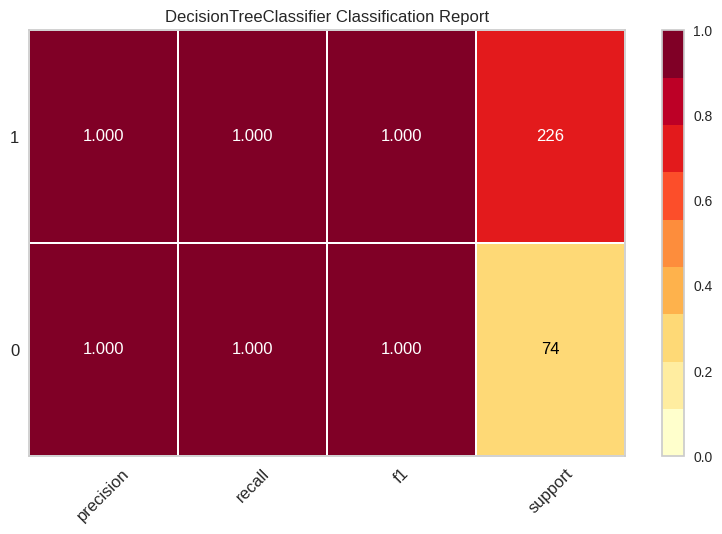

In [36]:
plot_model(dt, plot = 'class_report')

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Train test split
x_train, x_test, y_train,y_test = train_test_split(X_scaled,Y,test_size=0.2,random_state=6)

# Create a Random Forest Classifier object
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
predictions = clf.predict(x_test)


In [39]:
from sklearn.metrics import classification_report


print(classification_report(y_test, predictions, target_names=['0: fraud', '1: no fraud']))
#'Y': 0, #fraud   'N': 1  #no fraud

              precision    recall  f1-score   support

    0: fraud       1.00      1.00      1.00        40
 1: no fraud       1.00      1.00      1.00       160

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

